In [1]:
import cython
import numpy as np
import TidalPy
import CyRK
print('Cython', cython.__version__)
print('TidalPy', TidalPy.__version__)
print('CyRK', CyRK.__version__)

Cython 3.0.0
TidalPy 0.5.0a5.dev34
CyRK 0.8.5


In [2]:
%load_ext cython

## Radial Solver Function

In [3]:
%%cython -a --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False


Content of stdout:
_cython_magic_103ef21b9ab785d1dc0a04b0bf282fc1eb17dcb8.cpp
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_103ef21b9ab785d1dc0a04b0bf282fc1eb17dcb8.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_103ef21b9ab785d1dc0a04b0bf282fc1eb17dcb8.cp311-win_amd64.exp
Generating code
Finished generating code

In [47]:
%%cython --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libc.math cimport NAN, pi, isnan

from cpython.mem cimport PyMem_Free

import numpy as np
cimport numpy as np

from scipy.linalg.cython_lapack cimport zgesv

from scipy.constants import G as G_

from CyRK.utils.utils cimport  allocate_mem, reallocate_mem

# TODO: ReDimen Radial
from TidalPy.radial_solver.nondimensional import re_dimensionalize_radial_func

# Import cythonized functions
from TidalPy.utilities.dimensions.nondimensional cimport cf_non_dimensionalize_physicals

from TidalPy.RadialSolver.starting.driver cimport cf_find_starting_conditions
from TidalPy.RadialSolver.solutions cimport cf_find_num_solutions
from TidalPy.RadialSolver.interfaces.interfaces cimport cf_solve_upper_y_at_interface
from TidalPy.RadialSolver.derivatives.base cimport RadialSolverBase
from TidalPy.RadialSolver.derivatives.odes cimport cf_build_solver

from libcpp cimport bool as bool_cpp_t


# Setup globals
cdef double G
G = G_

# Maximum size for array building
cdef size_t MAX_NUM_Y      = 6
cdef size_t MAX_NUM_Y_REAL = 2 * MAX_NUM_Y
cdef size_t MAX_NUM_SOL    = 3

cdef class RadialSolverSolution():

    cdef public str status
    cdef public bool_cpp_t success

    cdef double complex* full_solution_ptr
    cdef double complex[::1] full_solution_view

    cdef size_t num_ys
    cdef size_t num_slices
    cdef size_t total_size
    cdef size_t num_solvers

    cdef tuple solution_types
    def __init__(
            self,
            size_t num_slices,
            tuple solve_for,
            size_t num_solvers
            ):

        # loop indicies
        cdef size_t i

        # Initialize pointers
        self.full_solution_ptr = NULL

        # Initialize status
        self.status = 'RadialSolverSolution has not had its status set.'
        self.success = False

        # Store number of solution types
        self.num_solvers = num_solvers
        self.solution_types = solve_for
        
        # Store size information
        self.num_slices = num_slices
        self.total_size = MAX_NUM_Y * self.num_slices * self.num_solvers

        # Have the radial solver take control of the full solution memory
        self.full_solution_ptr = <double complex*> allocate_mem(
            self.total_size * sizeof(double complex),
            'full_solution_ptr (RadialSolverSolution; init)'
            )
        if not (self.full_solution_ptr is NULL):
            self.full_solution_view = <double complex[:self.total_size]> self.full_solution_ptr
        
        # Set all values of the solution array to NANs. This ensures that if there is a problem with the solver then
        #  the solutions will be defined (but nan).
        for i in range(self.total_size):
            self.full_solution_ptr[i] = NAN

    @property
    def result(self):
        return np.ascontiguousarray(
            self.full_solution_view, dtype=np.complex128
            ).reshape((self.num_slices, self.num_solvers * MAX_NUM_Y)).T
    
    def __len__(self):
        """Return number of solution types."""
        return <Py_ssize_t>self.num_solvers
    
    def __getitem__(self, str solution_name):
        """Get a specific solution type array."""
        
        cdef size_t i
        cdef size_t requested_sol_num = 0
        cdef bool_cpp_t found = False
        cdef str sol_test_name
        for i in range(self.num_solvers):
            sol_test_name = self.solution_types[i]
            if sol_test_name == solution_name:
                requested_sol_num = i
                found = True
                break
        if not found:
            raise AttributeError('Unknown solution type requested. Key must match names passed to radial_solver "solve_for" argument and be lower case.')
        
        # Slice the result and return only the requested solution type.
        return self.result[MAX_NUM_Y * (requested_sol_num): MAX_NUM_Y * (requested_sol_num + 1)]

    def __dealloc__(self):

        # The RadialSolverSolution class has full control of the solution so it is responsible for releasing its memory.
        if not (self.full_solution_ptr is NULL):
            PyMem_Free(self.full_solution_ptr)


cdef RadialSolverSolution cf_radial_solver(
        const double[:] radius_array,
        const double[:] density_array,
        const double[:] gravity_array,
        const double[:] bulk_modulus_array,
        const double complex[:] complex_shear_modulus_array,
        double frequency,
        double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        unsigned int degree_l = 2,
        tuple solve_for = None,
        bool_cpp_t use_kamata = False,
        int integration_method = 1,
        double integration_rtol = 1.0e-4,
        double integration_atol = 1.0e-12,
        bool_cpp_t scale_rtols_by_layer_type = True,
        size_t max_num_steps = 500_000,
        size_t expected_size = 250,
        double max_step = 0,
        bool_cpp_t limit_solution_to_radius = True,
        bool_cpp_t nondimensionalize = True,
        bool_cpp_t verbose = False,
        bool_cpp_t raise_on_fail = False
        ):
    """
    Radial solver for 
    """
    # General indexing
    cdef size_t i, k

    # Layer | Solution | y indexing
    cdef size_t layer_i, solution_i, y_i, slice_i

    # Type conversions
    cdef double degree_l_dbl = <double>degree_l

    # Pull out key information
    cdef double radius_planet
    cdef size_t num_layers, num_interfaces, total_slices

    total_slices   = len(radius_array)
    radius_planet  = radius_array[total_slices - 1]
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1

    # Ensure there is at least one layer.
    if num_layers <= 0:
        raise AttributeError('Radial solver requires at least one layer.')

    # Ensure there are enough slices for radial interpolations.
    if total_slices <= (3 * num_layers):
        raise AttributeError('Radial solver requires at least 3 radial slices per layer (ideally >= 10 per).')

    # Copy the radial data into new pointers so the values can be manipulated inside this function.
    # Store all double-sized data in one large array.
    cdef double* radial_double_data_ptr = <double *> allocate_mem(
        4 * total_slices * sizeof(double),
        'radial_double_data_ptr (radial_solver; init)'
        )

    # Create user-friendly pointers to access blocks of that array
    cdef double* radius_array_ptr  = &radial_double_data_ptr[0]
    cdef double* density_array_ptr = &radial_double_data_ptr[total_slices]
    cdef double* gravity_array_ptr = &radial_double_data_ptr[2 * total_slices]
    cdef double* bulk_array_ptr    = &radial_double_data_ptr[3 * total_slices]

    # Opt: The data above is not stored in the most memory-efficient way since at each slice we will want all of:
    #  radius, density, gravity, etc. But since those are stored on separate rows, we have to go all the way to the end
    #  of a row to get the next item at slice_i. A fortran memory layout would be more efficient here.

    # Repeat for double complex-sized data.
    cdef double complex* cmplx_shear_array_ptr = <double complex *> allocate_mem(
        total_slices * sizeof(double complex),
        'cmplx_shear_array_ptr (radial_solver; init)'
        )

    # Populate the arrays (making a copy of values)
    for slice_i in range(total_slices):
        radius_array_ptr[slice_i]      = radius_array[slice_i]
        density_array_ptr[slice_i]     = density_array[slice_i]
        gravity_array_ptr[slice_i]     = gravity_array[slice_i]
        bulk_array_ptr[slice_i]        = bulk_modulus_array[slice_i]
        cmplx_shear_array_ptr[slice_i] = complex_shear_modulus_array[slice_i]

    # Non-dimensionalize inputs
    cdef double G_to_use = NAN
    cdef double frequency_to_use = NAN
    if nondimensionalize:
        cf_non_dimensionalize_physicals(
            total_slices,
            frequency,
            radius_planet,
            planet_bulk_density,
            radius_array_ptr,
            density_array_ptr,
            gravity_array_ptr,
            bulk_array_ptr,
            cmplx_shear_array_ptr,
            &frequency_to_use,
            &G_to_use
            )
        
        # Ensure that no errors occured during the non-dim process
        if isnan(frequency_to_use) or isnan(G_to_use):
            raise ValueError('NaNs encountered after non-dimensionalize call.')
    else:
        # Leave inputs alone.
        G_to_use         = G
        frequency_to_use = frequency

    cdef double surface_gravity = gravity_array_ptr[total_slices - 1]

    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    # The [5] represents the maximum number of solvers that can be invoked with a single call to radial_solver
    cdef size_t max_solvers = 5
    cdef size_t num_solvers = 1
    cdef str solver_name
    # 15 = 5 (max_solvers) * 3 (number of surface conditions)
    cdef double complex[15] boundary_conditions
    cdef double complex* bc_pointer = &boundary_conditions[0]

    if solve_for is None:
        # Assume we are solving for tides
        if nondimensionalize:
            bc_pointer[0] = 0.
            bc_pointer[1] = 0.
            bc_pointer[2] = (2. * degree_l_dbl + 1.) / 1.
        else:
            bc_pointer[0] = 0.
            bc_pointer[1] = 0.
            bc_pointer[2] = (2. * degree_l_dbl + 1.) / radius_planet
        solve_for = ('tidal',)
    else:
        # Use user input
        num_solvers = len(solve_for)
        if num_solvers > max_solvers:
            raise AttributeError(f'Unsupported number of solvers requested (max is {max_solvers}).')
        
        # Parse user input for the types of solvers that should be used.
        for i in range(num_solvers):
            solver_name = solve_for[i]
            if solver_name.lower() == 'tidal':
                if nondimensionalize:
                    bc_pointer[i * 3 + 0] = 0.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / 1.
                else:
                    bc_pointer[i * 3 + 0] = 0.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_planet
            elif solver_name.lower() == 'loading':
                if nondimensionalize:
                    bc_pointer[i * 3 + 0] = -(2. * degree_l_dbl + 1.) / 3.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / 1.
                else:
                    bc_pointer[i * 3 + 0] = -(2. * degree_l_dbl + 1.) * planet_bulk_density / 3.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_planet
            elif solver_name.lower() == 'free':
                bc_pointer[i * 3 + 0] = 0.
                bc_pointer[i * 3 + 1] = 0.
                bc_pointer[i * 3 + 2] = 0.
            else:
                raise NotImplementedError(f'Requested solver, {solver_name}, has not been implemented.\n\tSupported solvers are: tidal, loading, free.')

    # Integration information
    # Max step size
    cdef double max_step_touse
    cdef bool_cpp_t max_step_from_arrays
    max_step_from_arrays = False
    if max_step == 0:
        # If max_step is zero use the array information to determine max_step_size
        max_step_from_arrays = True
    else:
        # Otherwise use user input.
        max_step_touse = max_step

    # Setup tolerance arrays
    # For simplicity just make these all as large as the maximum number of ys.
    # Maximum number of ys = 6. Then 2x for conversion from complex to real
    cdef double[12] rtols_array
    cdef double* rtols_ptr = &rtols_array[0]
    cdef double[12] atols_array
    cdef double* atols_ptr = &atols_array[0]

    # Create storage for flags and information about each layer.
    cdef size_t* layer_int_data_ptr = <size_t *> allocate_mem(
        3 * num_layers * sizeof(size_t),
        'layer_int_data_ptr (radial_solver; init)'
        )

    cdef size_t* num_solutions_by_layer_ptr = &layer_int_data_ptr[0]
    cdef size_t* start_index_by_layer_ptr   = &layer_int_data_ptr[num_layers]
    cdef size_t* num_slices_by_layer_ptr    = &layer_int_data_ptr[2 * num_layers]

    # Unpack inefficient user-provided tuples into bool array
    cdef bool_cpp_t* layer_bool_data_ptr = <bool_cpp_t *> allocate_mem(
        3 * num_layers * sizeof(bool_cpp_t),
        'layer_bool_data_ptr (radial_solver; init)'
        )

    cdef bool_cpp_t* is_solid_by_layer_ptr          = &layer_bool_data_ptr[0]
    cdef bool_cpp_t* is_static_by_layer_ptr         = &layer_bool_data_ptr[num_layers]
    cdef bool_cpp_t* is_incompressible_by_layer_ptr = &layer_bool_data_ptr[2 * num_layers]

    # Opt: The bools above could be stores in a single char variable (per layer).
    #  Eg., 0x00 All false, 0x01 is solid, 0x10 is static and liquid, 0x11 is static and solid, etc.

    cdef bool_cpp_t layer_is_solid, layer_is_static, layer_is_incomp
    cdef bool_cpp_t layer_below_is_solid, layer_below_is_static, layer_below_is_incomp
    cdef double layer_upper_radius, radius_check
    cdef double layer_rtol_real, layer_rtol_imag, layer_atol_real, layer_atol_imag
    cdef size_t layer_slices
    cdef size_t num_sols, num_ys
    cdef size_t layer_below_num_sols, layer_below_num_ys
    cdef int num_sols_int

    for layer_i in range(num_layers):
        # Pull out information on this layer
        layer_is_solid     = is_solid_by_layer[layer_i]
        layer_is_static    = is_static_by_layer[layer_i]
        layer_is_incomp    = is_incompressible_by_layer[layer_i]
        layer_upper_radius = upper_radius_by_layer[layer_i]

        # Once the tuples are unpacked once store their values so we don't have to mess with them again.
        is_solid_by_layer_ptr[layer_i]          = layer_is_solid
        is_static_by_layer_ptr[layer_i]         = layer_is_static
        is_incompressible_by_layer_ptr[layer_i] = layer_is_incomp

        # Find number of solutions based on this layer's assumptions
        num_sols = cf_find_num_solutions(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp
            )
        num_ys = 2 * num_sols
        num_solutions_by_layer_ptr[layer_i] = num_sols

        # Determine how many slices are in this layer
        if layer_i == 0:
            # First layer starts at 0.
            start_index_by_layer_ptr[0] = 0
        else:
            # Not first layer. Starting point is based on number of slices in previous layer.
            start_index_by_layer_ptr[layer_i] = \
                start_index_by_layer_ptr[layer_i - 1] + num_slices_by_layer_ptr[layer_i - 1]

        layer_slices = 0
        for slice_i in range(start_index_by_layer_ptr[layer_i], total_slices):
            radius_check = radius_array[slice_i]
            if radius_check > layer_upper_radius:
                # We have passed this layer.
                break
            layer_slices += 1
        if layer_slices <= 3:
            raise ValueError('At least three layer slices per layer are required\n\tTry using more slices in the'
                             'input arrays.')
        num_slices_by_layer_ptr[layer_i] = layer_slices

    # We have all the size information needed to build storage pointers
    # Main storage pointer is setup like [layer_i][solution_i][y_i + r_i]
    cdef double complex*** main_storage = <double complex ***> allocate_mem(
        num_layers * sizeof(double complex**),
        'main_storage (radial_solver; init)'
        )

    cdef double complex** storage_by_solution = NULL
    cdef double complex* storage_by_y = NULL

    for layer_i in range(num_layers):
        num_sols     = num_solutions_by_layer_ptr[layer_i]
        layer_slices = num_slices_by_layer_ptr[layer_i]
        # Number of ys = 2x num sols
        num_ys = 2 * num_sols

        storage_by_solution = <double complex **> allocate_mem(
            num_sols * sizeof(double complex*), 
            'storage_by_solution (radial_solver; init)'
            ) 

        for solution_i in range(num_sols):
            storage_by_y = <double complex *> allocate_mem(
                layer_slices * num_ys * sizeof(double complex),
                'storage_by_y (radial_solver; init)'
                )

            storage_by_solution[solution_i] = storage_by_y
            storage_by_y = NULL
        main_storage[layer_i] = storage_by_solution
        storage_by_solution = NULL

    # Create storage for uppermost ys for each solution. We don't know how many solutions or ys per layer so assume the
    #  worst.
    cdef double complex[36] uppermost_y_per_solution
    cdef double complex* uppermost_y_per_solution_ptr = &uppermost_y_per_solution[0]

    # Layer specific pointers; set the size based on the layer with the most slices.
    cdef double* layer_radius_ptr
    cdef double* layer_density_ptr
    cdef double* layer_gravity_ptr
    cdef double* layer_bulk_mod_ptr
    cdef double complex* layer_shear_mod_ptr
    cdef double* layer_rtols_ptr
    cdef double* layer_atols_ptr

    # Properties at top and bottom of layer
    cdef double radius_lower, radius_upper
    cdef double density_lower, density_upper
    cdef double gravity_lower, gravity_upper
    cdef double bulk_lower
    cdef double complex shear_lower
    cdef tuple radial_span

    # Properties at interfaces between layers
    cdef double static_liquid_density
    cdef double interface_gravity
    cdef double last_layer_upper_gravity, last_layer_upper_density

    # Starting solutions (initial conditions / lower boundary conditions)
    # Allocate memory for the initial value arrays now. We don't know the number of solutions or ys. But the max number
    #  is not all that different from the min. So it is more efficient to assume the largest size.
    # Largest size = 6 (ys) x 3 (sols) = 18
    # For the "only_real" this is further multiplied by 2 since we convert the number of _complex_ ys to 2x _real_ ys
    cdef double complex[18] initial_y
    cdef double complex* initial_y_ptr = &initial_y[0]
    cdef double[36] initial_y_only_real
    cdef double* initial_y_only_real_ptr = &initial_y_only_real[0]
    cdef bool_cpp_t starting_y_check = False

    # Intermediate values
    cdef double complex dcomplex_tmp

    # Solver class
    cdef RadialSolverBase solver
    cdef bool_cpp_t cysolver_setup = False

    # Feedback
    cdef str feedback_str
    cdef bool_cpp_t error
    feedback_str = 'Starting integration'
    if verbose:
        print(feedback_str)
    error = False
    cdef size_t start_index

    # No matter the results of the integration, we know the shape and size of the final solution.
    # The number of rows will depend on if the user wants to simultaneously calculate loading Love numbers.
    cdef size_t num_output_ys = 6 * num_solvers
    
    # Build final output solution
    cdef RadialSolverSolution solution
    solution = RadialSolverSolution(total_slices, solve_for, num_solvers)

    # Get a reference pointer to solution array
    cdef double complex* solution_ptr = solution.full_solution_ptr

    # During collapse, variables for the layer above the target one are used. Declare these and preset them.
    cdef size_t layer_above_num_sols
    cdef double layer_above_lower_gravity
    cdef double layer_above_lower_density
    cdef double liquid_density_at_interface
    cdef bool_cpp_t layer_above_is_solid
    cdef bool_cpp_t layer_above_is_static
    cdef bool_cpp_t layer_above_is_incomp

    # The constant vectors are the same size as the number of solutions in the layer. But since the largest they can
    #  ever be is 3, it is more efficient to just preallocate them on the stack rather than dynamically allocate them
    #  on the heap.
    cdef double complex[3] constant_vector
    cdef double complex* constant_vector_ptr = &constant_vector[0]
    cdef double complex[3] layer_above_constant_vector
    cdef double complex* layer_above_constant_vector_ptr = &layer_above_constant_vector[0]

    # Allocate surface matrices. We only need one of these (which one depends on the uppermost layer type).
    # But, since there are only 3 and all of them are small, we will just allocate all of them separately on the stack.
    cdef double complex[3][3] surface_matrix_solid
    cdef double complex[2][2] surface_matrix_liquid_dynamic
    cdef double complex[1][1] surface_matrix_liquid_static
    cdef double complex* surface_matrix_ptr

    # OPT: Could reuse some of these variables so there are not so many being allocated for this function.
    cdef double complex y4_frac_1, y4_frac_2
    cdef double complex gamma_1, gamma_2
    cdef double complex lower_s1y1, lower_s1y2, lower_s1y5, lower_s1y6
    cdef double complex lower_s2y1, lower_s2y2, lower_s2y5, lower_s2y6
    cdef double complex lambda_1, lambda_2

    # Variables used to solve the linear equation at the planet's surface.
    # These are passed to the LAPACK solver.
    # Info = flag set by the solver. Set equal to -999. This will indicate that the solver has not been called yet.
    cdef int lapack_info
    # NRHS = number of solutions that will be solved at the same time. Only one will be solved per radial_solver call.
    cdef int lapack_nrhs
    # IPIV = Integer pivot array that is an additional output provided by ZGESV. It is not used but must be provided.
    #  It must be at least as large as the largest dimension of the input matrix, for this work that is 3.
    cdef int[10] lapack_ipiv
    cdef int* lapack_ipiv_ptr
    lapack_ipiv_ptr = &lapack_ipiv[0]

    # Shifted or reversed indices used during collapse.
    cdef size_t slice_i_shifted, layer_i_reversed

    try:
        for layer_i in range(num_layers):
            # Get layer's index information
            start_index  = start_index_by_layer_ptr[layer_i]
            layer_slices = num_slices_by_layer_ptr[layer_i]

            # Get solution and y information
            num_sols = num_solutions_by_layer_ptr[layer_i]
            num_ys   = 2 * num_sols

            # Setup pointer array slices starting at this layer's beginning
            layer_radius_ptr    = &radius_array_ptr[start_index]
            layer_density_ptr   = &density_array_ptr[start_index]
            layer_gravity_ptr   = &gravity_array_ptr[start_index]
            layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
            layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

            # Get physical parameters at the top and bottom of the layer
            radius_lower  = layer_radius_ptr[0]
            density_lower = layer_density_ptr[0]
            gravity_lower = layer_gravity_ptr[0]
            bulk_lower    = layer_bulk_mod_ptr[0]
            shear_lower   = layer_shear_mod_ptr[0]
            radius_upper  = layer_radius_ptr[layer_slices - 1]
            density_upper = layer_density_ptr[layer_slices - 1]
            gravity_upper = layer_gravity_ptr[layer_slices - 1]

            # Determine max step size (if not provided by user)
            if max_step_from_arrays:
                # Maximum step size during integration can not exceed the average radial slice size.
                max_step_touse = (radius_upper - radius_lower) / <double>layer_slices

            # Get assumptions for layer
            layer_is_solid  = is_solid_by_layer_ptr[layer_i]
            layer_is_static = is_static_by_layer_ptr[layer_i]
            layer_is_incomp = is_incompressible_by_layer_ptr[layer_i]

            # Determine rtols and atols for this layer.
            # Scale rtols by layer type
            for y_i in range(num_ys):
                # Default is that each layer's rtol and atol equal user input.
                # TODO: Change up the tolerance scaling between real and imaginary?
                layer_rtol_real = integration_rtol
                layer_rtol_imag = integration_rtol
                layer_atol_real = integration_atol
                layer_atol_imag = integration_atol

                if scale_rtols_by_layer_type:
                    # Certain layer assumptions can affect solution stability so use additional scales on the relevant rtols
                    # TODO test that these scales are the best.
                    if layer_is_solid:
                        # Scale y2 and y3 by 0.1
                        if (y_i == 1) or (y_i == 2):
                            # Scale both the real and imaginary portions by the same amount.
                            layer_rtol_real *= 0.1
                            layer_rtol_imag *= 0.1
                    else:
                        if not layer_is_static:
                            # Scale dynamic liquid layer's y2 by additional 0.01.
                            if (y_i == 1):
                                # Scale both the real and imaginary portions by the same amount.
                                layer_rtol_real *= 0.01
                                layer_rtol_imag *= 0.01
                # Populate rtol and atol pointers.
                rtols_ptr[2 * y_i]     = layer_rtol_real
                rtols_ptr[2 * y_i + 1] = layer_rtol_imag
                atols_ptr[2 * y_i]     = layer_atol_real
                atols_ptr[2 * y_i + 1] = layer_atol_imag

            # Find initial conditions for each solution at the base of this layer.
            radial_span = (radius_lower, radius_upper)
            if layer_i == 0:
                # Use initial condition function
                cf_find_starting_conditions(
                    layer_is_solid,
                    layer_is_static,
                    layer_is_incomp,
                    use_kamata,
                    frequency_to_use,
                    radius_lower,
                    density_lower,
                    bulk_lower,
                    shear_lower,
                    degree_l,
                    G_to_use,
                    MAX_NUM_Y, 
                    initial_y_ptr,
                    starting_y_check
                    )
            else:
                layer_below_is_solid  = is_solid_by_layer_ptr[layer_i - 1]
                layer_below_is_static = is_static_by_layer_ptr[layer_i - 1]
                layer_below_is_incomp = is_incompressible_by_layer_ptr[layer_i - 1]

                # Find gravity at the base interface using bottom of this layer and top of previous.
                interface_gravity = 0.5 * (gravity_lower + last_layer_upper_gravity)

                # Find the density needed for some initial conditions.
                if layer_is_solid and layer_below_is_solid:
                    # Both layers are solid. A liquid interface density is not needed.
                    static_liquid_density = NAN
                elif not layer_is_solid and layer_below_is_solid:
                    # Layer below is solid, this layer is liquid. Use its density.
                    static_liquid_density = density_lower
                elif layer_is_solid and not layer_below_is_solid:
                    # Layer below is liquid, this layer is solid. Use layer below's density.
                    static_liquid_density = last_layer_upper_density
                else:
                    # Both layers are liquid. Choose the layer's density which is static.
                    if layer_is_static and layer_below_is_static:
                        # Both layers are static.
                        # TODO: Not sure what to do here so just use this layer's density.
                        static_liquid_density = density_lower
                    elif layer_is_static and not layer_below_is_static:
                        # This layer is static, one below is not. Use this layer's density
                        static_liquid_density = density_lower
                    elif not layer_is_static and layer_below_is_static:
                        # This layer is dynamic, layer below is static. Use layer below's density
                        static_liquid_density = last_layer_upper_density
                    else:
                        # Both layers are dynamic. Static liquid density is not needed.
                        static_liquid_density = NAN

                # TODO: For now we are not using the initial y pointer correctly so it is set pointing to a different part of memory at layer==0.
                #  We want it pointing back to the original array.
                initial_y_ptr = &initial_y[0]

                # Find the starting values for this layer using the results a the top of the previous layer + an interface
                #  function.
                cf_solve_upper_y_at_interface(
                    uppermost_y_per_solution_ptr,
                    initial_y_ptr,
                    layer_below_num_sols,
                    num_sols,
                    layer_below_num_ys,
                    num_ys,
                    layer_below_is_solid,
                    layer_below_is_static,
                    layer_below_is_incomp,
                    layer_is_solid,
                    layer_is_static,
                    layer_is_incomp,
                    interface_gravity,
                    static_liquid_density,
                    G_to_use
                    )

            # Change initial conditions into 2x real values instead of complex for integration
            for solution_i in range(num_sols):
                for y_i in range(num_ys):
                    dcomplex_tmp = initial_y_ptr[solution_i * MAX_NUM_Y + y_i]
                    initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i]     = dcomplex_tmp.real
                    initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i + 1] = dcomplex_tmp.imag

            # Build solver instance
            solver = cf_build_solver(
                layer_is_solid,
                layer_is_static,
                layer_is_incomp,
                layer_slices,
                2 * num_ys,  # Solver needs to know how many ys it is working with. 2x ys in this case.
                layer_radius_ptr,
                layer_density_ptr,
                layer_gravity_ptr,
                layer_bulk_mod_ptr,
                layer_shear_mod_ptr,
                frequency_to_use,
                degree_l,
                G_to_use,
                radial_span,
                &initial_y_only_real_ptr[0],  # Start the pointer at the beginning of the array
                atols_ptr,
                rtols_ptr,
                integration_method,
                max_step_touse,
                max_num_steps,
                expected_size,
                limit_solution_to_radius
                )
            cysolver_setup = True

            # Get storage pointer for this layer
            storage_by_solution = main_storage[layer_i]

            # Solve for each solution
            for solution_i in range(num_sols):

                if solution_i > 0:
                    # Reset solver with new initial condition (this is already done for j==0)
                    # This pointer has already been passed to the solver during initialization but we need the values at
                    #  the next solution. Pass new pointer at that address.
                    solver.change_y0_pointer(&initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL], auto_reset_state=False)

                ###### Integrate! #######
                solver._solve(reset=True)
                #########################

                # Check for problems
                if not solver.success:
                    # Problem with integration.
                    feedback_str = f'Integration problem at layer {layer_i}; solution {solution_i}:\n\t{solver.message}'
                    if verbose:
                        print(feedback_str)
                    if raise_on_fail:
                        raise RuntimeError(feedback_str)
                    error = True
                    break

                # If no problems, store results.
                # Need to make a copy because the solver pointers will be reallocated during the next solution.
                # Get storage pointer for this solution
                storage_by_y = storage_by_solution[solution_i]
                for slice_i in range(layer_slices):
                    for y_i in range(num_ys):
                        # Convert 2x real ys to 1x complex ys
                        dcomplex_tmp = \
                            solver.solution_y_ptr[slice_i * (2 * num_ys) + (2 * y_i)] + \
                            1.0j * solver.solution_y_ptr[slice_i * (2 * num_ys) + (2 * y_i) + 1]

                        storage_by_y[slice_i * num_ys + y_i] = dcomplex_tmp
                        # Store top most result for initial condition for the next layer
                        if slice_i == (layer_slices - 1):
                            # Tell top storage to point to the top-most value in the main storage arrays.
                            uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = dcomplex_tmp

            if error:
                # Error was encountered during integration
                break

            # Prepare for next layer
            layer_below_num_sols = num_sols
            layer_below_num_ys   = num_ys
            last_layer_upper_gravity = gravity_upper
            last_layer_upper_density = density_upper
            del solver
            cysolver_setup = False

        if error:
            feedback_str = 'Integration failed.'
            if verbose:
                print(feedback_str)
            if raise_on_fail:
                raise RuntimeError(feedback_str)

        else:
            feedback_str = 'Integration completed for all layers. Beginning solution collapse.'

            for k in range(num_solvers):
                feedback_str = f'Collapsing radial solutions for solver {k}.'

                # Reset variables for this solver
                lapack_info = -999
                lapack_nrhs = 1
                constant_vector_ptr[0] = NAN
                constant_vector_ptr[1] = NAN
                constant_vector_ptr[2] = NAN
                layer_above_num_sols        = 0
                layer_above_lower_gravity   = 0.
                layer_above_lower_density   = 0.
                liquid_density_at_interface = 0.
                layer_above_is_solid        = False
                layer_above_is_static       = False
                layer_above_is_incomp       = False

                if verbose:
                    print(feedback_str)
                # Collapse the multiple solutions for each layer into one final combined solution.

                # Work from the surface to the core.
                for layer_i in range(num_layers):
                    layer_i_reversed = num_layers - (layer_i + 1)

                    # Pull out layer information.
                    start_index  = start_index_by_layer_ptr[layer_i_reversed]
                    layer_slices = num_slices_by_layer_ptr[layer_i_reversed]

                    # Get solution and y information
                    num_sols     = num_solutions_by_layer_ptr[layer_i_reversed]
                    num_sols_int = <int>num_sols
                    num_ys       = 2 * num_sols

                    # Setup pointer array slices starting at this layer's beginning
                    layer_radius_ptr    = &radius_array_ptr[start_index]
                    layer_density_ptr   = &density_array_ptr[start_index]
                    layer_gravity_ptr   = &gravity_array_ptr[start_index]
                    layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
                    layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

                    # Get physical parameters at the top and bottom of the layer
                    radius_lower  = layer_radius_ptr[0]
                    density_lower = layer_density_ptr[0]
                    gravity_lower = layer_gravity_ptr[0]
                    bulk_lower    = layer_bulk_mod_ptr[0]
                    shear_lower   = layer_shear_mod_ptr[0]
                    radius_upper  = layer_radius_ptr[layer_slices - 1]
                    density_upper = layer_density_ptr[layer_slices - 1]
                    gravity_upper = layer_gravity_ptr[layer_slices - 1]

                    # Get assumptions for layer
                    layer_is_solid  = is_solid_by_layer_ptr[layer_i_reversed]
                    layer_is_static = is_static_by_layer_ptr[layer_i_reversed]
                    layer_is_incomp = is_incompressible_by_layer_ptr[layer_i_reversed]

                    # Get full solutions for this layer
                    storage_by_solution = main_storage[layer_i_reversed]

                    # Get value at the top of the layer
                    for solution_i in range(num_sols):
                        for y_i in range(num_ys):
                            uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = \
                                storage_by_solution[solution_i][(layer_slices - 1) * num_ys + y_i]

                    if layer_i == 0:
                        # Working on surface (uppermost) layer.
                        # Create coefficient matrix based on surface layer type.
                        if layer_is_solid:
                            # Set pointer to correct matrix
                            surface_matrix_ptr = &surface_matrix_solid[0][0]

                            # At the surface: y_2 = S_1; y_4 = S_4; y_6 = S_6 [See: B.37 in KTC21; 16 in KMN15]
                            # We will set the constant vector equal to the surface boundary condition.
                            #  It will be overwritten with the solution to the linear solution.
                            constant_vector_ptr[0] = bc_pointer[k * 3 + 0]
                            constant_vector_ptr[1] = bc_pointer[k * 3 + 1]
                            constant_vector_ptr[2] = bc_pointer[k * 3 + 2]

                            # The definitions above need to be transposed as the LAPACK solver TidalPy uses requires
                            #  FORTRAN-ordered arrays.
                            surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                            surface_matrix_ptr[1] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                            surface_matrix_ptr[2] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 5]
                            surface_matrix_ptr[3] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                            surface_matrix_ptr[4] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]
                            surface_matrix_ptr[5] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 5]
                            surface_matrix_ptr[6] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]
                            surface_matrix_ptr[7] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                            surface_matrix_ptr[8] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 5]

                        else:
                            if layer_is_static:
                                # Set pointer to correct matrix
                                surface_matrix_ptr = &surface_matrix_liquid_dynamic[0][0]

                                # Unlike the dynamic liquid layer, a static liquid layer's y_2 is undefined. That leads to one less boundary condition
                                #  and one less solution (1 total).
                                #  At the surface, y_7 = S_7 [See: Eq. 17, 10 in S74]

                                # We will set the constant vector equal to the surface boundary condition.
                                #  It will be overwritten with the solution to the linear solution.
                                # y_7 = y_6 + (4 pi G / g) y_2
                                constant_vector_ptr[0] = \
                                    bc_pointer[k * 3 + 2] + \
                                    bc_pointer[k * 3 + 0] * (4. * pi * G_to_use / surface_gravity)

                                # These are unused. Set to NAN so if they do get used we might be able to catch it.
                                constant_vector_ptr[1] = NAN
                                constant_vector_ptr[2] = NAN

                                # Note: for a static liquid layer, y_7 held in index 1 (index 0 is y_5).
                                surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                            else:
                                # Set pointer to correct matrix
                                surface_matrix_ptr = &surface_matrix_liquid_static[0][0]

                                # Unlike the solid layer, a liquid layer's y_4 is undefined. That leads to one less boundary condition and one
                                #  less solution (2 total).
                                #  At the surface, y_2 = S_1; y_6 = S_6 [See: Eq. B.38 in KTC21; Eq. 17 in KMN15

                                # We will set the constant vector equal to the surface boundary condition.
                                #  It will be overwritten with the solution to the linear solution.
                                # The surface boundary condition will still have 3 members. Drop the one related to y_4
                                constant_vector_ptr[0] = bc_pointer[k * 3 + 0]
                                constant_vector_ptr[1] = bc_pointer[k * 3 + 2]

                                # The last constant is unused. Set to NAN so if they do get used we might be able to catch it.
                                constant_vector_ptr[2] = NAN

                                # Build y-solution matrix to be applied to the surface.
                                # Note: for a dynamic liquid, y_2 and y_6 are held at indices 1 and 3 respectively
                                surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                                surface_matrix_ptr[1] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                                surface_matrix_ptr[2] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                                surface_matrix_ptr[3] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]


                        # Find the solution to the linear equation
                        # ZGESV computes the solution to system of linear equations A * X = B for GE matrices
                        # See https://www.netlib.org/lapack/explore-html/d6/d10/group__complex16_g_esolve_ga531713dfc62bc5df387b7bb486a9deeb.html#ga531713dfc62bc5df387b7bb486a9deeb
                        zgesv(&num_sols_int, &lapack_nrhs, surface_matrix_ptr, &num_sols_int, lapack_ipiv_ptr,
                            constant_vector_ptr, &num_sols_int, &lapack_info)

                        if lapack_info != 0:
                            feedback_str = \
                                (f'Error encountered while applying surface boundary condition. ZGESV code: {lapack_info}'
                                f'\nThe solutions may not be valid at the surface.')
                            if verbose:
                                print(feedback_str)
                            if raise_on_fail:
                                raise RuntimeError(feedback_str)
                            error = True
                            break
                    else:
                        # Working on interior layers. Will need to find the constants of integration based on the layer above.

                        # Interfaces are defined at the bottom of the layer in question. However, this function is calculating
                        #  the transition at the top of each layer as it works its way down.
                        #  So, for interface values, we actually need the ones of the layer above us.
                        interface_gravity = 0.5 * (gravity_upper + layer_above_lower_gravity)
                        liquid_density_at_interface = NAN
                        if not layer_is_solid:
                            if layer_is_static:
                                liquid_density_at_interface = density_upper
                            elif not layer_above_is_solid and layer_above_is_static:
                                liquid_density_at_interface = layer_above_lower_density
                            else:
                                liquid_density_at_interface = density_upper
                        elif not layer_above_is_solid:
                            liquid_density_at_interface = layer_above_lower_density

                        if layer_is_solid:
                            if layer_above_is_solid:
                                # Both layers are solid. Constants are the same.
                                for solution_i in range(num_sols):
                                    constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                            else:
                                # Create some helper functions that will be needed
                                y4_frac_1 = (
                                        -uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3] /
                                        uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                                    )
                                y4_frac_2 = (
                                        -uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3] /
                                        uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                                    )

                                if layer_above_is_static:
                                    # Need to find 3 solid constants from 1 liquid constant
                                    # S74, Page 131
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    # Derived by JPR based on Eq 21 (2nd line) of S74
                                    gamma_1 = (uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1] +
                                            y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]) - \
                                        (liquid_density_at_interface *
                                        (interface_gravity * (
                                                uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 0] +
                                                y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 0]) -
                                        (uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 4] +
                                        y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 4])
                                        )
                                        )
                                    gamma_2 = \
                                        (uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1] +
                                        y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]) - \
                                        (liquid_density_at_interface *
                                        (interface_gravity * (
                                                uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 0] +
                                                y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 0]) -
                                        (uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 4] +
                                        y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 4])
                                        )
                                        )

                                    constant_vector_ptr[1] = (-gamma_1 / gamma_2) * constant_vector_ptr[0]
                                    # TS72, Eq. 142 (utilizes y_4 = 0)
                                    constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]

                                else:
                                    # Need to find 3 solid constants from 2 liquid constants
                                    # TS72, Eq. 144
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]
                                    # TS72, Eq. 142 (utilizes y_4 = 0)
                                    constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]
                        else:
                            if layer_is_static:
                                if not layer_above_is_solid:
                                    # Liquid layer above
                                    if layer_above_is_static:
                                        # Both layers are static liquids. Constants are the same.
                                        constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    else:
                                        # Dynamic liquid above
                                        # JPR decided to follow a similar approach as Eq. 20 in S74:
                                        #   Treat the lower static liquid as normal.
                                        #   The upper dynamic liquid layer is treated like the solid layer in Eq. 20 except
                                        #    that y_3 is undefined as is "set 3" solution mentioned in that text.
                                        constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                else:
                                    # Solid layer above
                                    # Based on S74. The constant in this layer is just equal to the constant in solution 1 of the
                                    #  layer above.
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            else:
                                if not layer_above_is_solid:
                                    # Liquid layer above
                                    if layer_above_is_static:
                                        # Need to find 2 liquid (dynamic) constants from 1 liquid (static) constant
                                        # S74, Page 131
                                        constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                        # Derived by JPR based on Eq 21 (2nd line) of S74
                                        # Pull out ys
                                        # # Solution 1
                                        lower_s1y1 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 0]
                                        lower_s1y2 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                                        lower_s1y5 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 2]
                                        lower_s1y6 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                                        # # Solution 2
                                        lower_s2y1 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 0]
                                        lower_s2y2 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                                        lower_s2y5 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 2]
                                        lower_s2y6 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]
                                        # lambda_j = (y_2j - rho * ( g * y_1j - y_5j))
                                        lambda_1 = lower_s1y2 - liquid_density_at_interface * \
                                                (interface_gravity * lower_s1y1 - lower_s1y5)
                                        lambda_2 = lower_s2y2 - liquid_density_at_interface * \
                                                (interface_gravity * lower_s2y1 - lower_s2y5)
                                        constant_vector_ptr[1] = (-lambda_1 / lambda_2) * constant_vector_ptr[0]
                                    else:
                                        # Both layers are dynamic liquids. Constants are the same.
                                        for solution_i in range(num_sols):
                                            constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                                else:
                                    # Solid layer above
                                    # TS72 Eqs. 148-149
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]

                    # Use constant vectors to find the full y from all of the solutions in this layer
                    for solution_i in range(num_sols):
                        for slice_i in range(layer_slices):
                            slice_i_shifted = start_index + slice_i
                            for y_i in range(6):
                                if layer_is_solid:
                                    # All ys can be calculated
                                    if solution_i == 0:
                                        # Initialize values
                                        solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] = \
                                            (constant_vector_ptr[solution_i] *
                                            storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                    else:
                                        # Add new results to old value
                                        solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] += \
                                            (constant_vector_ptr[solution_i] *
                                            storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                else:
                                    if layer_is_static:
                                        # Liquid static layers only has y5 (stored at index 0).
                                        if y_i == 4:
                                            if solution_i == 0:
                                                # Initialize values
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] = \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + 0])
                                            else:
                                                # Add new results to old value
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] += \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + 0])
                                        else:
                                            solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] = NAN
                                    else:
                                        # Liquid dynamic layers have y1, y2, y5, y6 (indices 0, 1, 2, 3)
                                        if (y_i == 0) or (y_i == 1):
                                            if solution_i == 0:
                                                # Initialize values
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] = \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                            else:
                                                # Add new results to old value
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] += \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                        elif (y_i == 4) or (y_i == 5):
                                            if solution_i == 0:
                                                # Initialize values
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] = \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                            else:
                                                # Add new results to old value
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] += \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                        elif y_i == 3:
                                            # y4 is undefined no matter what
                                            solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + y_i)] = NAN

                                        # For liquid dynamic layers we can calculate y3 based on the other ys.
                                        if y_i == 5 and solution_i == (num_sols - 1):
                                            # All other ys have been found. Now we can find y3.
                                            solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + 2)] = \
                                                (1. / (frequency_to_use**2 * layer_radius_ptr[slice_i])) * \
                                                (solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + 0)] * layer_gravity_ptr[slice_i] -
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + 1)] / layer_density_ptr[slice_i] -
                                                solution_ptr[slice_i_shifted * num_output_ys + (k * 6 + 4)])

                    # Setup for next layer
                    layer_above_lower_gravity = gravity_lower
                    layer_above_lower_density = density_lower
                    layer_above_is_solid      = layer_is_solid
                    layer_above_is_static     = layer_is_static
                    layer_above_is_incomp     = layer_is_incomp
                    layer_above_num_sols      = num_sols

                    if num_sols == 1:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = NAN
                        layer_above_constant_vector_ptr[2] = NAN
                    elif num_sols == 2:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = constant_vector_ptr[1]
                        layer_above_constant_vector_ptr[2] = NAN
                    elif num_sols == 3:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = constant_vector_ptr[1]
                        layer_above_constant_vector_ptr[2] = constant_vector_ptr[2]
    finally:
        # Free memory
        if cysolver_setup:
            del solver

        # Release radial property pointers
        if not (radial_double_data_ptr is NULL):
            radius_array_ptr  = NULL
            density_array_ptr = NULL
            gravity_array_ptr = NULL
            bulk_array_ptr    = NULL
            PyMem_Free(radial_double_data_ptr)
            radial_double_data_ptr = NULL
        if not (cmplx_shear_array_ptr is NULL):
            PyMem_Free(cmplx_shear_array_ptr)
            cmplx_shear_array_ptr = NULL

        # Deconstruct main solution pointer
        # Main storage pointers are structured like [layer_i][solution_i][y_i + slice_i]
        # Then main storage
        if not (main_storage is NULL):
            storage_by_solution = NULL
            storage_by_y = NULL
            for layer_i in range(num_layers):
                num_sols = num_solutions_by_layer_ptr[layer_i]
                if not (main_storage[layer_i] is NULL):
                    for solution_i in range(num_sols):
                        if not (main_storage[layer_i][solution_i] is NULL):
                            PyMem_Free(main_storage[layer_i][solution_i])
                            main_storage[layer_i][solution_i] = NULL
                    
                    PyMem_Free(main_storage[layer_i])
                    main_storage[layer_i] = NULL
            PyMem_Free(main_storage)
            main_storage = NULL

        # Release layer information pointers
        if not (layer_int_data_ptr is NULL):
            num_solutions_by_layer_ptr = NULL
            start_index_by_layer_ptr = NULL
            num_slices_by_layer_ptr = NULL
            PyMem_Free(layer_int_data_ptr)
            layer_int_data_ptr = NULL
        
        if not (layer_bool_data_ptr is NULL):
            is_solid_by_layer_ptr = NULL
            is_static_by_layer_ptr = NULL
            is_incompressible_by_layer_ptr = NULL
            PyMem_Free(layer_bool_data_ptr)
            layer_bool_data_ptr = NULL

    # Update solution status and return
    solution.status = feedback_str
    solution.success = not error

    return solution


def radial_solver(
        const double[:] radius_array,
        const double[:] density_array,
        const double[:] gravity_array,
        const double[:] bulk_modulus_array,
        const double complex[:] complex_shear_modulus_array,
        double frequency,
        double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        unsigned int degree_l = 2,
        tuple solve_for = None,
        bool_cpp_t use_kamata = False,
        int integration_method = 1,
        double integration_rtol = 1.0e-4,
        double integration_atol = 1.0e-12,
        bool_cpp_t scale_rtols_by_layer_type = True,
        size_t max_num_steps = 500_000,
        size_t expected_size = 250,
        double max_step = 0,
        bool_cpp_t limit_solution_to_radius = True,
        bool_cpp_t nondimensionalize = True,
        bool_cpp_t verbose = False,
        bool_cpp_t raise_on_fail = False
        ):
    
    return cf_radial_solver(
            radius_array,
            density_array,
            gravity_array,
            bulk_modulus_array,
            complex_shear_modulus_array,
            frequency,
            planet_bulk_density,
            is_solid_by_layer,
            is_static_by_layer,
            is_incompressible_by_layer,
            upper_radius_by_layer,
            degree_l,
            solve_for,
            use_kamata,
            integration_method,
            integration_rtol,
            integration_atol,
            scale_rtols_by_layer_type,
            max_num_steps,
            expected_size,
            max_step,
            limit_solution_to_radius,
            nondimensionalize,
            verbose,
            raise_on_fail)


Content of stdout:
_cython_magic_f40005f3856b2ccc36195b4f427e5b5ab2441121.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_f40005f3856b2ccc36195b4f427e5b5ab2441121.cpp(34806): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_f40005f3856b2ccc36195b4f427e5b5ab2441121.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_f40005f3856b2ccc36195b4f427e5b5ab2441121.cp311-win_amd64.exp
Generating code
Finished generating code

## Homogen Solid

Start
True
Collapsing radial solutions for solver 0.


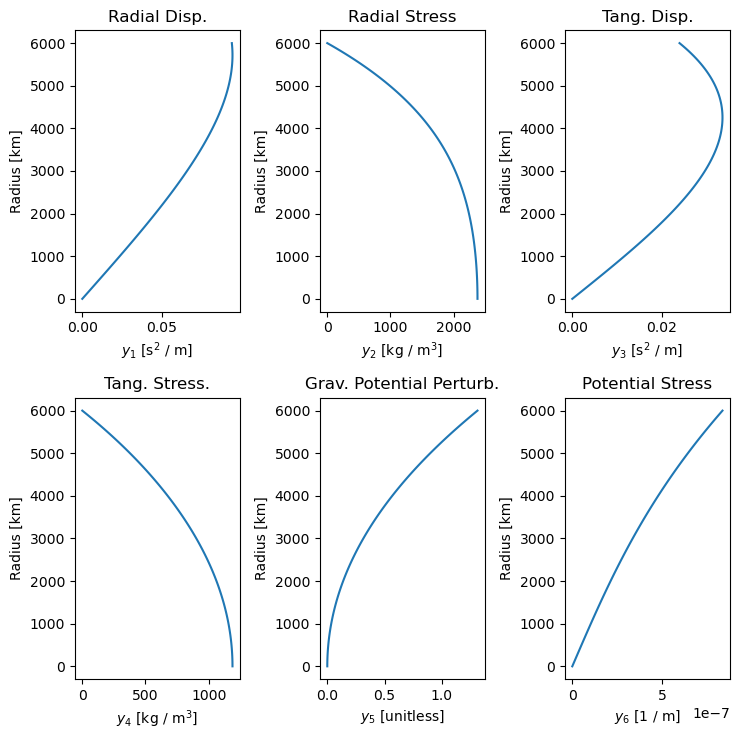

In [57]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
frequency = 0.00001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)

density_array = 3500. * np.ones_like(radius_array)

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)

viscosity_array = 1.0e20 * np.ones_like(radius_array)

shear_array = 5.0e10 * np.ones_like(radius_array)

result = np.empty((6, N), dtype=np.complex128, order='C')

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (True,)
is_static_by_layer = (True,)
is_incompressible_by_layer = (False,)
indicies = (radius_array >= 0.,)
upper_radius_by_layer = (radius_array[-1],)

print('Start')
result = radial_solver(
        radius_array,
        density_array,
        gravity_array,
        bulk_modulus_array,
        complex_shear_modulus_array,
        frequency,
        planet_bulk_density,
        is_solid_by_layer,
        is_static_by_layer,
        is_incompressible_by_layer,
        upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = True,
        integration_method = 1,
        integration_rtol = 1.0e-6,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = True,
        max_num_steps = 500_000,
        expected_size = 250,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False
        )
print(result.success)
print(result.status)
_ = yplot(result.result, radius_array)


In [23]:
result.result.shape

(12, 100)

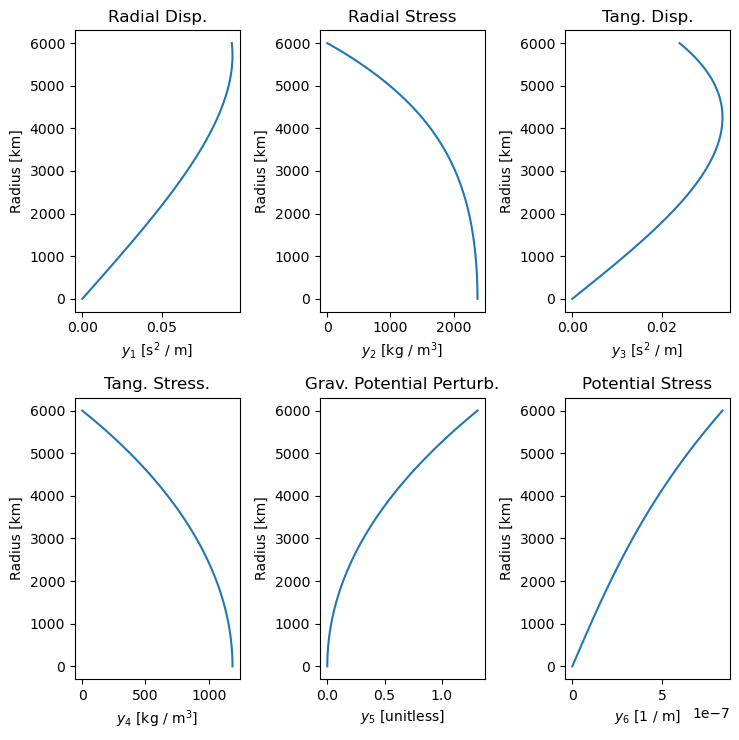

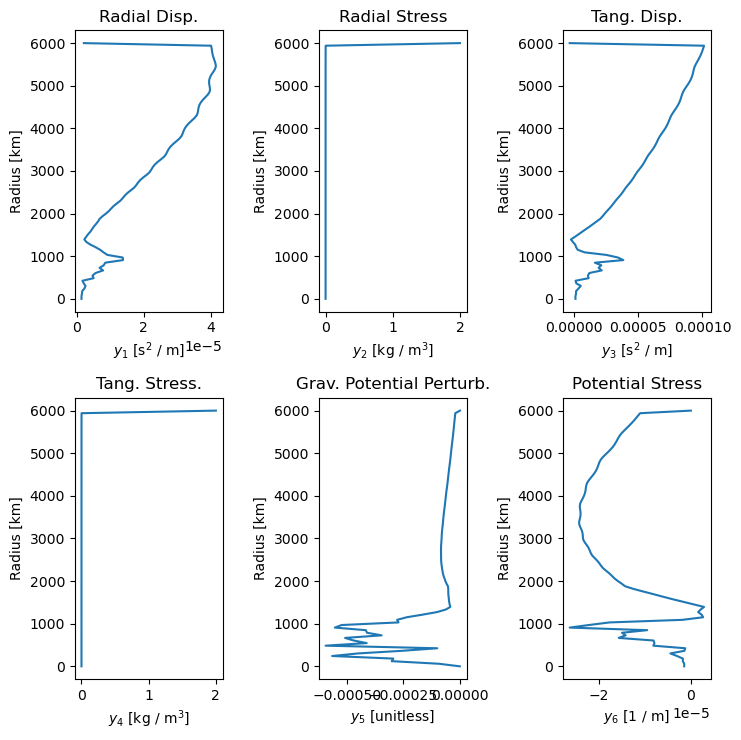

In [59]:
from TidalPy.radial_solver.numerical import radial_solver as radial_solver_old

indicies = (radius_array>=0.,)

out_old = radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-5,integration_atol = 1.0e-9,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot(2 * (out_old - result.result) / (out_old + result.result) , radius_array)

In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [ ]:
# OLD (Not using NonDim):
# 312ms, 311ms, 298ms
# 297ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

In [ ]:
# NEW (Not using NonDim):
# 4.93ms, 4.9ms
# 2.57ms, 2.33ms
# 2.42ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False)

## Liquid-Solid

True


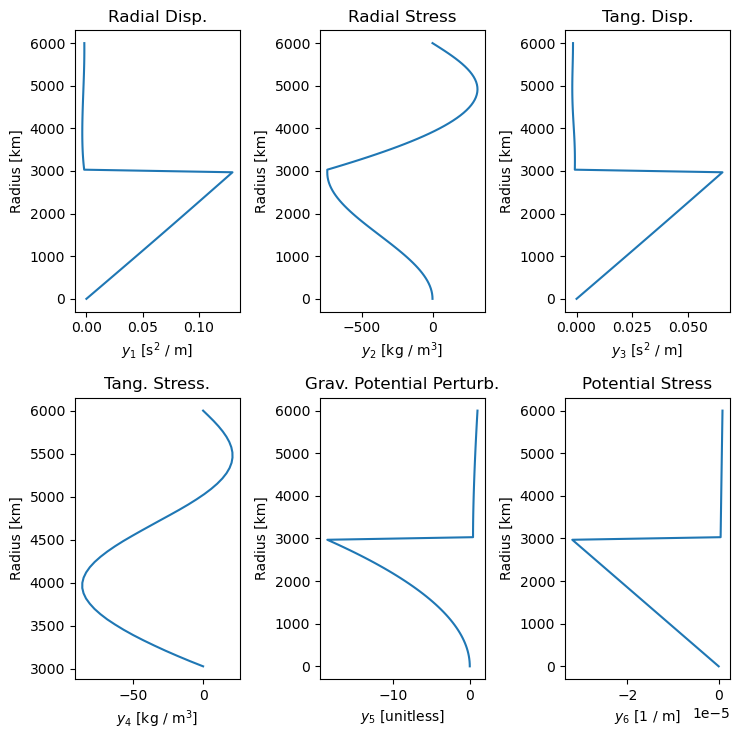

In [8]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
frequency = 0.01
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
CMB_radius = radius_array[-1] / 2.

density_array = 3500. * np.ones_like(radius_array)
density_array[radius_array <= CMB_radius] = 6000.

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)
bulk_modulus_array[radius_array <= CMB_radius] = 5.0e11

viscosity_array = 1.0e20 * np.ones_like(radius_array)
viscosity_array[radius_array <= CMB_radius] = 1.0e15

shear_array = 5.0e10 * np.ones_like(radius_array)
shear_array[radius_array <= CMB_radius] = 0.

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (False, True,)
is_static_by_layer = (False, False,)
is_incompressible_by_layer = (False, False,)
indicies = (radius_array <= CMB_radius, radius_array > CMB_radius)
upper_radius_by_layer = (radius_array[-1]/2., radius_array[-1],)

result, success = radial_solver(
        radius_array,
        density_array,
        gravity_array,
        bulk_modulus_array,
        complex_shear_modulus_array,
        frequency,
        planet_bulk_density,
        is_solid_by_layer,
        is_static_by_layer,
        is_incompressible_by_layer,
        upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = True,
        integration_method = 1,
        integration_rtol = 1.0e-6,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = True,
        max_num_steps = 5_000_000,
        expected_size = 250,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False
        )

print(success)
_ = yplot(result, radius_array)


In [9]:
from TidalPy.radial_solver.numerical import radial_solver as radial_solver_old


out_old = radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-12,integration_atol = 1.0e-12,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - result), radius_array)


KeyboardInterrupt



In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [ ]:
# OLD (Not using NonDim):
# 144ms, 142ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

In [ ]:
# NEW (Not using NonDim):
# 1.31ms, 1.31ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)

## Solid-Liquid-Solid

In [ ]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
# frequency = 0.001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
ICB_radius = radius_array[-1] * (1/3)
CMB_radius = radius_array[-1] * (2/3)

IC_index = radius_array <= ICB_radius
OC_index = np.logical_and(radius_array > ICB_radius, radius_array <= CMB_radius)
mantle_index = radius_array > CMB_radius

density_array = np.empty_like(radius_array)
density_array[IC_index] = 11000.
density_array[OC_index] = 9000.
density_array[mantle_index] = 3950.

bulk_modulus_array = np.empty_like(radius_array)
bulk_modulus_array[IC_index] = 200.e9
bulk_modulus_array[OC_index] = 50.e9
bulk_modulus_array[mantle_index] = 100.e9

viscosity_array = np.empty_like(radius_array)
viscosity_array[IC_index] = 1.0e24
viscosity_array[OC_index] = 1000.
viscosity_array[mantle_index] = 1.0e18

shear_array = np.empty_like(radius_array)
shear_array[IC_index] = 100.0e9
shear_array[OC_index] = 0.
shear_array[mantle_index] = 50.0e9

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (True, False, True)
is_static_by_layer = (False, True, False)
is_incompressible_by_layer = (False, False, False)

indicies = (IC_index, OC_index, mantle_index)
upper_radius_by_layer = (ICB_radius, CMB_radius, radius_array[-1],)

out = radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)

#_ = yplot(out[:, 0:N:2], radius_array[0:N:2])
_ = yplot(out, radius_array)

In [ ]:
out_old = radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - out), radius_array)

In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [ ]:
# OLD (Not using NonDim):
# 356ms, 353ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

In [ ]:
# NEW (Not using NonDim):
# 2.23ms, 2.28ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)